In [1]:
import pandas as pd
from itertools import permutations

def generate_permutations(lst):
    """
    Generate all permutations of the input list.

    Parameters:
    lst (list): The list of elements to permute.

    Returns:
    list of tuples: A list where each tuple is a permutation of the input list.
    """
    return list(permutations(lst))

def get_sorted_descriptions_from_dict(x, y):
    # Create lists for different conditions
    start = [item['Description'] for item in x if item['IsStart'] == True]
    middle = [item['Description'] for item in x if item['IsStart'] != True and item['IsEnd'] != True]
    middle.sort(key = lambda x : int(x[1:]))
    end = [item['Description'] for item in x if item['IsEnd'] == True]

    # out = []
    # for p in generate_permutations(middle):
    #     out.append(start + ["START_END"]  + list(p) + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"])

    # Concatenate the lists
    if y == "6B" or len(middle) < 4:
        return [start + ["START_END"]  + middle + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"]]
    else:
        
        out = [start + ["START_END"]  + middle + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"]]
        middle[0], middle[1] = middle[1], middle[0]
        out.append(start + ["START_END"]  + middle + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"])
        middle[0], middle[1] = middle[1], middle[0]
        middle[-1], middle[-2] = middle[-2], middle[-1]
        out.append(start + ["START_END"]  + middle + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"])
        middle[0], middle[1] = middle[1], middle[0]
        out.append(start + ["START_END"]  + middle + ["MIDDLE_END"] + end + ["END_ROUTE"] + [y] + ["GRADE_END"])
        return out
    

def preprocess_data(filename, necessary_columns):
    df = pd.read_json(filename).T
    df = df[necessary_columns]

    df = df[df['Grade']!='8B+']
    df = df[df['Grade']!='8B']
    df = df[df['Grade']!='8A+']

    df = df.reset_index(drop=True)
    

    X, y = df["Moves"], df["Grade"]
    n = len(X)

    data = []

    for i in range(n):
        data += get_sorted_descriptions_from_dict(X[i],y[i]) 
    

    return data

def drop_duplicates(list_of_lists):
    """
    Drop duplicates from a list of lists.

    Parameters:
    list_of_lists (list of lists): The input list containing lists which may have duplicates.

    Returns:
    list of lists: A list with duplicates removed.
    """
    # Convert each inner list to a tuple (tuples are hashable and can be added to a set)
    seen = set()
    unique_list_of_lists = [tuple(lst) for lst in list_of_lists if tuple(lst) not in seen and not seen.add(tuple(lst))]

    # Convert tuples back to lists
    return [list(tpl) for tpl in unique_list_of_lists]

columns = ["Method", "Grade", "Name", "Rating", "Repeats", "Moves"]

data = preprocess_data("Raw\moonboard_problems_setup_2016.json", columns)
print(len(data))

data = drop_duplicates(data)
print(len(data))

92295
92127


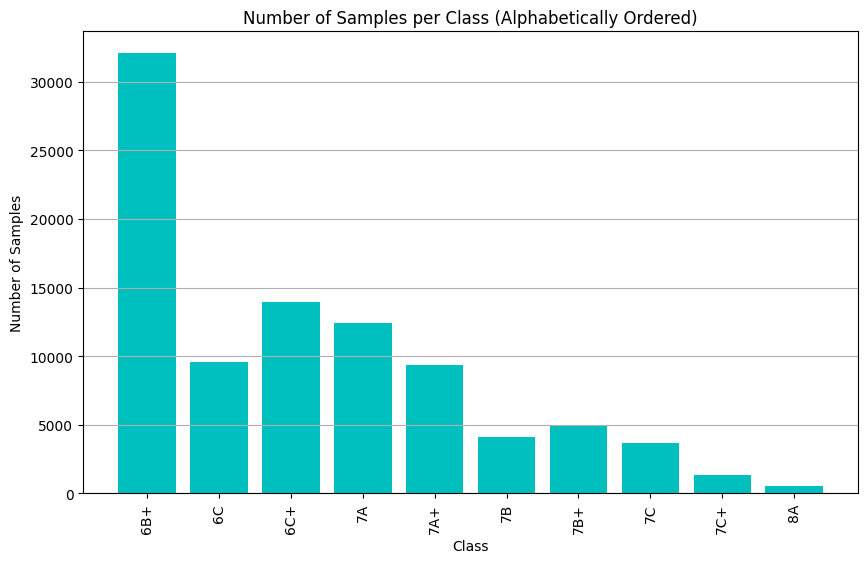

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the classes (grades) from the dataset
classes = [d[-2] for d in data]

# Count the number of occurrences of each class
class_counts = Counter(classes)

# Sort class labels alphabetically
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_classes, sorted_counts, color='c')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class (Alphabetically Ordered)')
plt.xticks(rotation=90)  # Rotate x labels if they are long
plt.grid(axis='y')

plt.show()


# LSTM Classification

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Custom dataset
class ClimbingRouteDataset(Dataset):
    def __init__(self, sequences, grades, vocab, max_length):
        self.sequences = sequences
        self.grades = grades
        self.vocab = vocab
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        grade = self.grades[idx]
        
        seq_indices = [self.vocab.get(hold, 0) for hold in sequence]
        seq_indices = seq_indices[:self.max_length] + [0] * (self.max_length - len(seq_indices))
        
        return torch.tensor(seq_indices), torch.tensor(grade)

# LSTM model
class ClimbingGradePredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        output = self.fc(hidden[-1])
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for sequences, grades in train_loader:
        sequences, grades = sequences.to(device), grades.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, grades)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, grades in test_loader:
            sequences, grades = sequences.to(device), grades.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, grades)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += grades.size(0)
            correct += (predicted == grades).sum().item()
    accuracy = correct / total
    return total_loss / len(test_loader), accuracy

def plot_loss_curves(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
# Sample data (replace with your full dataset)
sequences = data
grades = [s[-2] for s in sequences]
sequences = [s[:-2] for s in sequences]

# Create vocabulary and encode grades
vocab = {hold: idx for idx, hold in enumerate(set(hold for seq in sequences for hold in seq), start=1)}
vocab['<PAD>'] = 0
grade_encoder = LabelEncoder()
encoded_grades = grade_encoder.fit_transform(grades)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(sequences, encoded_grades, test_size=0.2, random_state=42)

# Create datasets and dataloaders
max_length = max(len(seq) for seq in sequences)
train_dataset = ClimbingRouteDataset(X_train, y_train, vocab, max_length)
test_dataset = ClimbingRouteDataset(X_test, y_test, vocab, max_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ClimbingGradePredictor(
    vocab_size=len(vocab),
    embed_dim=16,
    hidden_dim=128,
    num_layers=3,
    num_classes=len(grade_encoder.classes_)
).to(device)

# Class weights for balanced training
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print("Class Weighting in Loss Function")
for k in list(zip(grade_encoder.classes_, np.log(class_weights + np.e))):
        print(k)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(np.log(class_weights + np.e), dtype=torch.float).to(device))

optimizer = optim.Adam(model.parameters(), lr=0.001)


Class Weighting in Loss Function
('6B+', 1.100437555088908)
('6C', 1.3038525094321243)
('6C+', 1.2178374535560184)
('7A', 1.2419072185815996)
('7A+', 1.3077102234046691)
('7B', 1.6004041271921927)
('7B+', 1.5203433686767018)
('7C', 1.641942697035619)
('7C+', 2.249822343011615)
('8A', 2.9251179655913444)


In [10]:
# Training loop
num_epochs = 500
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/500, Train Loss: 1.6401, Test Loss: 1.6271, Test Accuracy: 0.4088


In [ ]:
# Plot training and testing loss curves
plot_loss_curves(train_losses, test_losses)

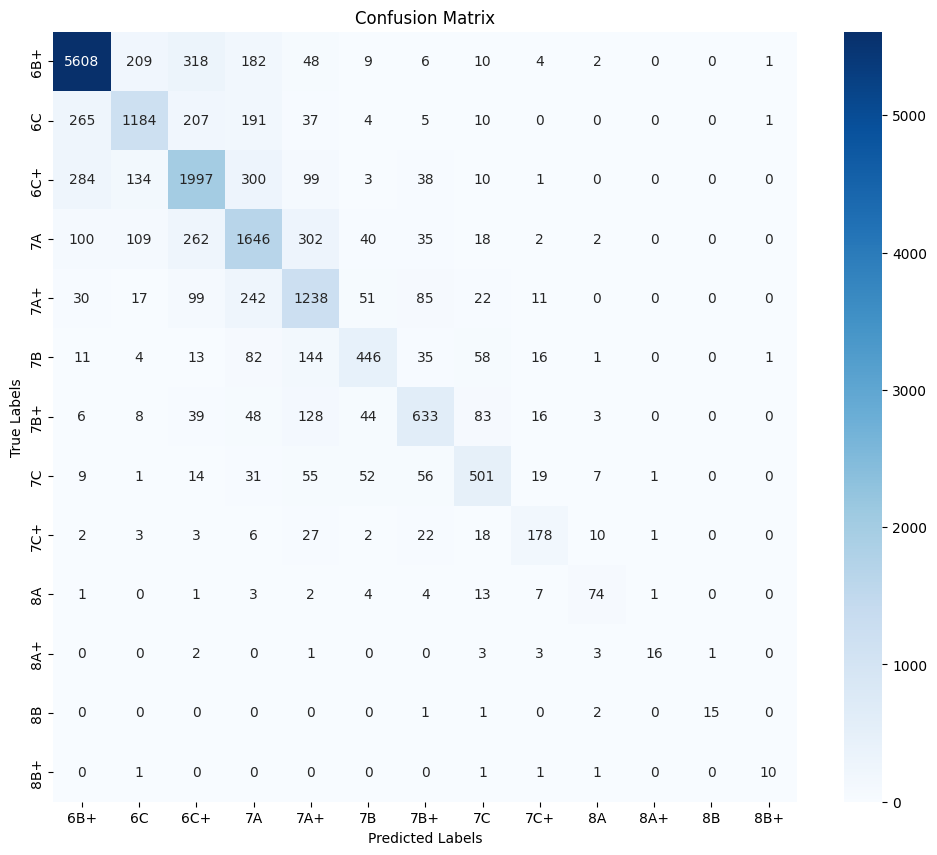

Majority Class Size: 0.34602693784821764
Accuracy 1: 0.7327311083464055
Accuracy 2: 0.8621734191594093
Accuracy 3: 0.9492075512522313
Accuracy 4: 0.9785254503164386
Accuracy 5: 0.9924271109428247


In [134]:
from sklearn.metrics import confusion_matrix

# Collect true and predicted labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for sequences, grades in test_loader:
        sequences, grades = sequences.to(device), grades.to(device)
        outputs = model(sequences)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(grades.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 10))  # Adjust the size (width, height) as needed

# Plot confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=grade_encoder.classes_, yticklabels=grade_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

def calculate_accuracy_with_diagonals(conf_matrix, width=3):
    # Number of classes
    n_classes = conf_matrix.shape[0]
    
    # Compute the sum of the leading diagonal and adjacent diagonals
    total_correct = 0
    total_samples = np.sum(conf_matrix)
    
    for i in range(n_classes):
        for j in range(max(0, i - width + 1), min(n_classes, i + width)):
            if abs(i - j) < width:
                total_correct += conf_matrix[i, j]
    
    accuracy = total_correct / total_samples
    return accuracy

print("Majority Class Size:", np.sum(conf_matrix[0]) / np.sum(conf_matrix))

# Compute accuracy
print("Accuracy 1:", calculate_accuracy_with_diagonals(conf_matrix, width=1))
print("Accuracy 2:", calculate_accuracy_with_diagonals(conf_matrix, width=2))
print("Accuracy 3:", calculate_accuracy_with_diagonals(conf_matrix, width=3))
print("Accuracy 4:", calculate_accuracy_with_diagonals(conf_matrix, width=4))
print("Accuracy 5:", calculate_accuracy_with_diagonals(conf_matrix, width=5))


# Transformer Model

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Custom dataset
class ClimbingRouteDataset(Dataset):
    def __init__(self, sequences, grades, vocab, max_length):
        self.sequences = sequences
        self.grades = grades
        self.vocab = vocab
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        grade = self.grades[idx]
        
        # Convert sequence to indices
        seq_indices = [self.vocab.get(hold, 0) for hold in sequence]
        seq_indices = seq_indices[:self.max_length] + [0] * (self.max_length - len(seq_indices))
        
        return torch.tensor(seq_indices), torch.tensor(grade)

# Transformer model for grade prediction
class ClimbingGradeTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, ff_dim, num_classes, max_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim, max_length)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.transformer_encoder(x.transpose(0, 1)).transpose(0, 1)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for sequences, grades in train_loader:
        sequences, grades = sequences.to(device), grades.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, grades)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for sequences, grades in test_loader:
            sequences, grades = sequences.to(device), grades.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, grades)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += grades.size(0)
            correct += (predicted == grades).sum().item()
    
    accuracy = correct / total
    return total_loss / len(test_loader), accuracy

# Main execution
if __name__ == "__main__":
    # Sample data (replace with your full dataset)
    sequences = data
    grades = [s[-2] for s in sequences]
    sequences = [s[:-2] for s in sequences] # Corresponding grades for the sequences
    
    # Create vocabulary and encode grades
    vocab = {hold: idx for idx, hold in enumerate(set(hold for seq in sequences for hold in seq), start=1)}
    vocab['<PAD>'] = 0
    
    grade_encoder = LabelEncoder()
    encoded_grades = grade_encoder.fit_transform(grades)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(sequences, encoded_grades, test_size=0.2, random_state=42)
    
    # Create datasets and dataloaders
    max_length = max(len(seq) for seq in sequences)
    train_dataset = ClimbingRouteDataset(X_train, y_train, vocab, max_length)
    test_dataset = ClimbingRouteDataset(X_test, y_test, vocab, max_length)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    # Initialize model and training components
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ClimbingGradeTransformer(
        vocab_size=len(vocab),
        embed_dim=64,
        num_heads=4,
        num_layers=2,
        ff_dim=128,
        num_classes=len(grade_encoder.classes_),
        max_length=max_length
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    num_epochs = 500
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Predict grade for a new route
    new_route = ['F5', 'START_END', 'H10', 'E10', 'G13', 'E15', 'G17', 'F8', 'MIDDLE_END', 'E18', 'END_ROUTE']
    new_route_tensor = torch.tensor([vocab.get(hold, 0) for hold in new_route]).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(new_route_tensor)
        predicted_grade_idx = torch.argmax(output, dim=1).item()
        predicted_grade = grade_encoder.inverse_transform([predicted_grade_idx])[0]
    
    print(f"Predicted grade for the new route: {predicted_grade}")

Epoch 1/500, Train Loss: 1.7326, Test Loss: 1.6909, Test Accuracy: 0.3765
Epoch 2/500, Train Loss: 1.6324, Test Loss: 1.6139, Test Accuracy: 0.3892
Epoch 3/500, Train Loss: 1.6013, Test Loss: 1.6132, Test Accuracy: 0.3883
Epoch 4/500, Train Loss: 1.5762, Test Loss: 1.6094, Test Accuracy: 0.3836
Epoch 5/500, Train Loss: 1.5637, Test Loss: 1.5967, Test Accuracy: 0.3997
Epoch 6/500, Train Loss: 1.5421, Test Loss: 1.5815, Test Accuracy: 0.3915
Epoch 7/500, Train Loss: 1.5261, Test Loss: 1.6411, Test Accuracy: 0.3902
Epoch 8/500, Train Loss: 1.5097, Test Loss: 1.6005, Test Accuracy: 0.3970
Epoch 9/500, Train Loss: 1.4961, Test Loss: 1.5889, Test Accuracy: 0.3966
Epoch 10/500, Train Loss: 1.4806, Test Loss: 1.5980, Test Accuracy: 0.3937
Epoch 11/500, Train Loss: 1.4656, Test Loss: 1.6298, Test Accuracy: 0.3931
Epoch 12/500, Train Loss: 1.4486, Test Loss: 1.6277, Test Accuracy: 0.3854
Epoch 13/500, Train Loss: 1.4347, Test Loss: 1.6313, Test Accuracy: 0.3877
Epoch 14/500, Train Loss: 1.4208, 

KeyboardInterrupt: 